# OBJECT DETECTION

In [2]:
coco_labels = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
    "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
    "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "couch", "potted plant", "bed", "dining table", "toilet", "TV", "laptop",
    "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]


In [3]:
!pip install cython pillow>=7.0.0 numpy>=1.18.1 opencv-python>=4.1.2 torch>=1.9.0 --extra-index-url https://download.pytorch.org/whl/cpu torchvision>=0.10.0 --extra-index-url https://download.pytorch.org/whl/cpu pytest==7.1.3 tqdm==4.64.1 scipy>=1.7.3 matplotlib>=3.4.3 mock==4.0.3
!pip install cython pillow>=7.0.0 numpy>=1.18.1 opencv-python>=4.1.2 torch>=1.9.0 --extra-index-url https://download.pytorch.org/whl/cu102 torchvision>=0.10.0 --extra-index-url https://download.pytorch.org/whl/cu102 pytest==7.1.3 tqdm==4.64.1 scipy>=1.7.3 matplotlib>=3.4.3 mock==4.0.3
!pip install imageai --upgrade


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from imageai.Detection import ObjectDetection

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath("retinanet_resnet50_fpn_coco-eeacb38b.pth")
# detector.setModelPath("Downloads/retinanet_resnet50_fpn_coco-eeacb38b.pth")


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_background_objects(detections):
    """
    Analyze background objects from detections using COCO dataset categories
    Returns dictionary with background analysis results
    """
    # COCO dataset background categories
    indoor_objects = [
        'chair', 'couch', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
        'microwave', 'oven', 'sink', 'refrigerator', 'clock', 'vase'
    ]
    
    outdoor_man_made = [
        'bench', 'parking meter', 'stop sign', 'fire hydrant', 'traffic light',
        'building', 'fence', 'wall', 'bridge', 'road'
    ]
    
    vehicle_objects = [
        'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat'
    ]
    
    sports_objects = [
        'sports ball', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'frisbee'
    ]
    
    # Initialize counters
    background_analysis = {
        'indoor_count': 0,
        'outdoor_manmade_count': 0,
        'vehicle_count': 0,
        'sports_count': 0,
        'detected_objects': [],
        'is_indoor': False,
        'is_urban': False
    }
    
    # Count objects in each category
    for detection in detections:
        obj_name = detection["name"].lower()
        background_analysis['detected_objects'].append(obj_name)
        
        if obj_name in indoor_objects:
            background_analysis['indoor_count'] += 1
        elif obj_name in outdoor_man_made:
            background_analysis['outdoor_manmade_count'] += 1
        elif obj_name in vehicle_objects:
            background_analysis['vehicle_count'] += 1
        elif obj_name in sports_objects:
            background_analysis['sports_count'] += 1
    
    # Determine environment type based on object counts
    if background_analysis['indoor_count'] > 1:
        background_analysis['is_indoor'] = True
    
    if (background_analysis['outdoor_manmade_count'] + 
        background_analysis['vehicle_count']) > 2:
        background_analysis['is_urban'] = True
    
    return background_analysis

def is_natural_environment(image, detections):
    """
    Determine if image represents a natural environment based on combined criteria
    of greenery, natural elements, and animal types
    """
    # Convert BGR to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define range of green color in HSV
    lower_green = np.array([35, 25, 25])
    upper_green = np.array([85, 255, 255])
    
    # Create mask for green colors
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    
    # Calculate ratio of green pixels
    green_ratio = np.sum(green_mask > 0) / (image.shape[0] * image.shape[1])
    
    # Define object categories
    nature_objects = ['tree', 'trees', 'grass', 'mountain', 'hill', 'forest', 'plant', 'water', 'river', 'lake']
    wild_animals = ['elephant', 'lion', 'tiger', 'leopard', 'cheetah', 'zebra', 'giraffe', 
                   'monkey', 'gorilla', 'rhinoceros', 'hippopotamus', 'deer', 'antelope',
                   'bear', 'wolf', 'fox', 'snake']
    domestic_animals = ['dog', 'cat', 'cow', 'sheep', 'horse', 'goat', 'chicken', 
                       'pig', 'donkey', 'rabbit']
    
    # Check for different types of objects
    natural_elements = [detected["name"].lower() for detected in detections 
                       if detected["name"].lower() in nature_objects]
    wild_animals_detected = [detected["name"].lower() for detected in detections 
                           if detected["name"].lower() in wild_animals]
    domestic_animals_detected = [detected["name"].lower() for detected in detections 
                               if detected["name"].lower() in domestic_animals]
    
    has_natural_elements = len(natural_elements) > 0
    has_wild_animals = len(wild_animals_detected) > 0
    has_domestic_animals = len(domestic_animals_detected) > 0
    
    # Define minimum green ratio thresholds
    MIN_GREEN_RATIO = 0.15  # Minimum green ratio for natural environment
    
    # Classification logic with stricter criteria
    if has_wild_animals:
        # For jungle classification, require either sufficient greenery OR natural elements
        if green_ratio > MIN_GREEN_RATIO or has_natural_elements:
            return "jungle"
        else:
            return "other"  # Not enough natural elements for jungle
            
    elif has_domestic_animals:
        # For hill classification, check for natural elements or minimal greenery
        if green_ratio > MIN_GREEN_RATIO or has_natural_elements:
            return "hill"
        else:
            return "other"  # Not enough natural elements for hill
            
    elif has_natural_elements:
        # If no animals but natural elements present
        if green_ratio > MIN_GREEN_RATIO:
            return "hill"  # Default to hill for natural scenes without animals
        else:
            return "other"
            
    return "other"

def enhanced_environment_classification(image, detections):
    """
    Enhanced environment classification combining natural environment detection
    with background object analysis
    """
    # Get natural environment classification
    natural_env = is_natural_environment(image, detections)
    
    # Get background analysis
    background = detect_background_objects(detections)
    
    # Combine classifications for final determination
    if natural_env != "other":
        if background['is_urban']:
            if natural_env == "hill":
                return "urban park"
            else:
                return "urban wildlife"
        return natural_env
    
    elif background['is_indoor']:
        return "indoor"
    elif background['is_urban']:
        return "urban"
    elif background['sports_count'] > 1:
        return "sports venue"
    else:
        return "other"

def process_images(input_images, detector, coco_labels=None):
    """
    Process multiple images with enhanced environment detection and visualization
    """
    all_class_probabilities = []
    final_detections = [[] for _ in range(len(input_images))]
    bounding_boxes = [[] for _ in range(len(input_images))]
    
    for i, input_image in enumerate(input_images):
        # Perform object detection
        detections = detector.detectObjectsFromImage(
            input_image=input_image,
            output_image_path=f"detected/detected_objects_{i}.jpg",
            extract_detected_objects=False
        )
        
        # Load original image
        output_image = cv2.imread(input_image)
        
        # Get enhanced environment classification
        environment = enhanced_environment_classification(output_image, detections)
        
        # Get background analysis
        background_info = detect_background_objects(detections)
        
        # Print detailed detection information for debugging
        print(f"\nImage {i} Analysis:")
        print("Detected objects:", [d["name"] for d in detections])
        print("Background analysis:", background_info)
        # print(f"Environment classification: {environment}")
        
        for detection in detections:
            detected_class = detection["name"]
            detected_probability = detection["percentage_probability"]
            box_points = detection["box_points"]
            final_detections[i].append(detected_class)
            bounding_boxes[i].append(box_points)
            
            # Draw bounding box and label
            x1, y1, x2, y2 = box_points
            cv2.rectangle(output_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
            label = f"{detected_class} ({detected_probability:.2f}%)"
            cv2.putText(output_image, label, (x1, y1 - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            
            # Prepare class probability vector
            if coco_labels:
                class_prob_vector = [0] * len(coco_labels)
                if detected_class in coco_labels:
                    class_prob_vector[coco_labels.index(detected_class)] = detected_probability
                all_class_probabilities.append(class_prob_vector)
        
        # Add environment and background info to image
        # cv2.putText(output_image, f"Environment: {environment}", (10, 30),
        #             cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        # if background_info['is_indoor']:
        #     cv2.putText(output_image, "Indoor Scene", (10, 60),
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        # if background_info['is_urban']:
        #     cv2.putText(output_image, "Urban Scene", (10, 90),
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Display the image
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Image {i+1} ")
        plt.show()
    
    return final_detections, bounding_boxes, all_class_probabilities

C:\Users\KHUSHI\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KHUSHI\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\KHUSHI\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
C:\Users\KHUSHI\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are de


Image 0 Analysis:
Detected objects: ['giraffe', 'person', 'giraffe', 'person']
Background analysis: {'indoor_count': 0, 'outdoor_manmade_count': 0, 'vehicle_count': 0, 'sports_count': 0, 'detected_objects': ['giraffe', 'person', 'giraffe', 'person'], 'is_indoor': False, 'is_urban': False}


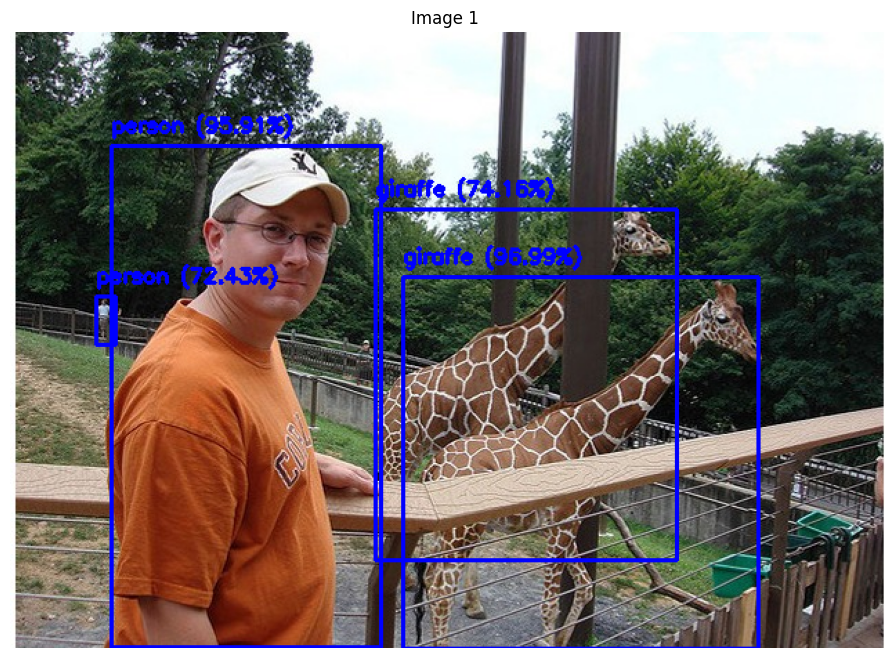


Image 1 Analysis:
Detected objects: ['giraffe', 'giraffe', 'giraffe']
Background analysis: {'indoor_count': 0, 'outdoor_manmade_count': 0, 'vehicle_count': 0, 'sports_count': 0, 'detected_objects': ['giraffe', 'giraffe', 'giraffe'], 'is_indoor': False, 'is_urban': False}


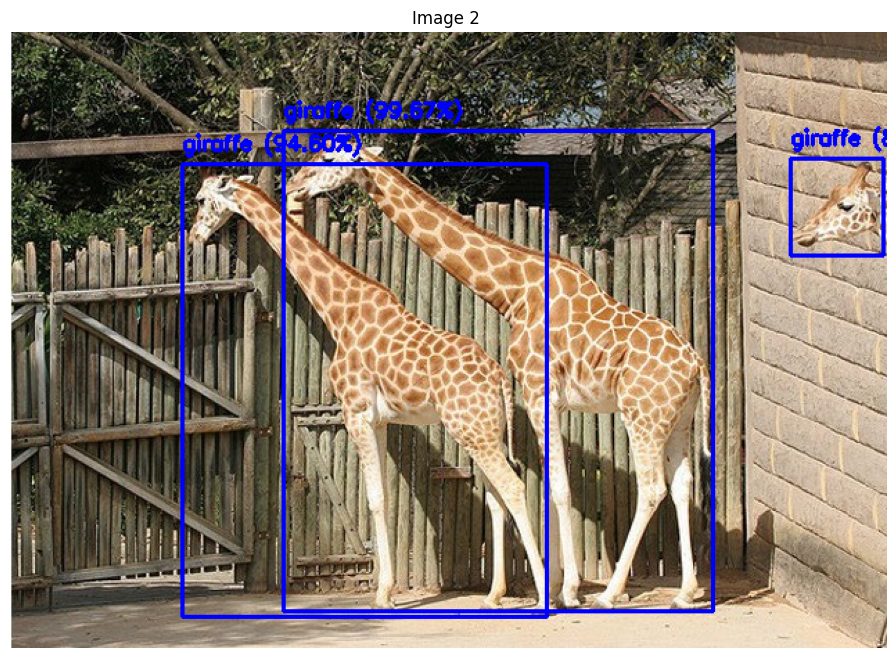


Image 2 Analysis:
Detected objects: ['giraffe', 'person', 'person', 'person', 'person', 'person', 'person']
Background analysis: {'indoor_count': 0, 'outdoor_manmade_count': 0, 'vehicle_count': 0, 'sports_count': 0, 'detected_objects': ['giraffe', 'person', 'person', 'person', 'person', 'person', 'person'], 'is_indoor': False, 'is_urban': False}


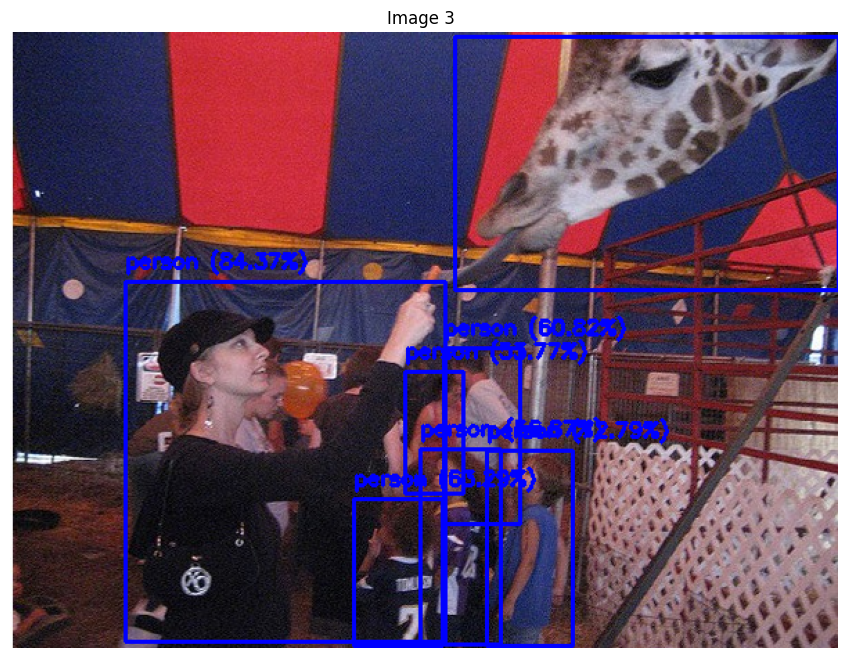


Image 3 Analysis:
Detected objects: ['giraffe']
Background analysis: {'indoor_count': 0, 'outdoor_manmade_count': 0, 'vehicle_count': 0, 'sports_count': 0, 'detected_objects': ['giraffe'], 'is_indoor': False, 'is_urban': False}


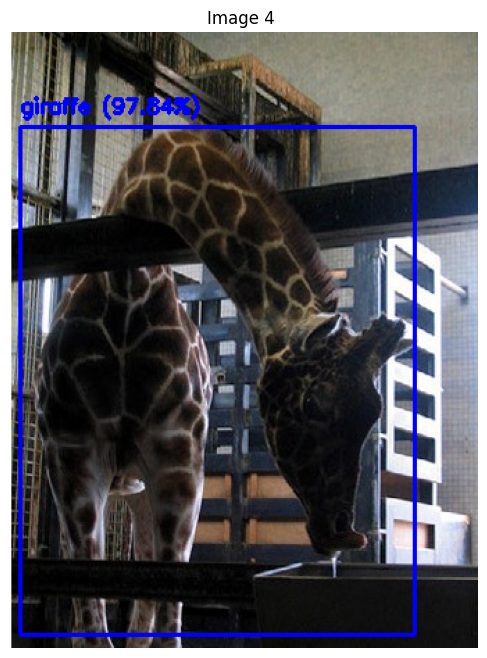


Image 4 Analysis:
Detected objects: ['giraffe', 'giraffe', 'giraffe', 'giraffe']
Background analysis: {'indoor_count': 0, 'outdoor_manmade_count': 0, 'vehicle_count': 0, 'sports_count': 0, 'detected_objects': ['giraffe', 'giraffe', 'giraffe', 'giraffe'], 'is_indoor': False, 'is_urban': False}


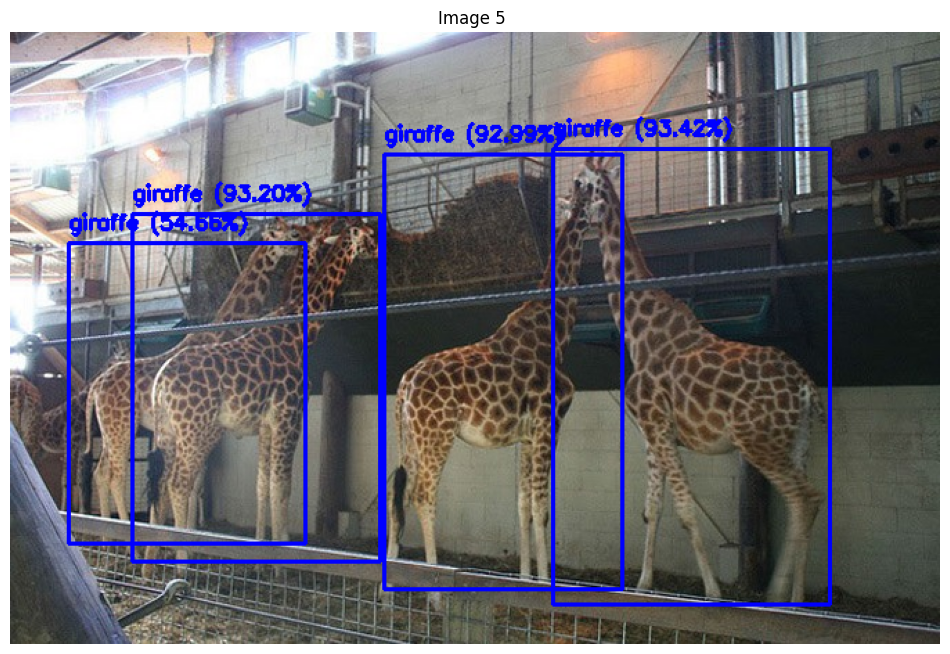


Image 5 Analysis:
Detected objects: ['giraffe', 'giraffe']
Background analysis: {'indoor_count': 0, 'outdoor_manmade_count': 0, 'vehicle_count': 0, 'sports_count': 0, 'detected_objects': ['giraffe', 'giraffe'], 'is_indoor': False, 'is_urban': False}


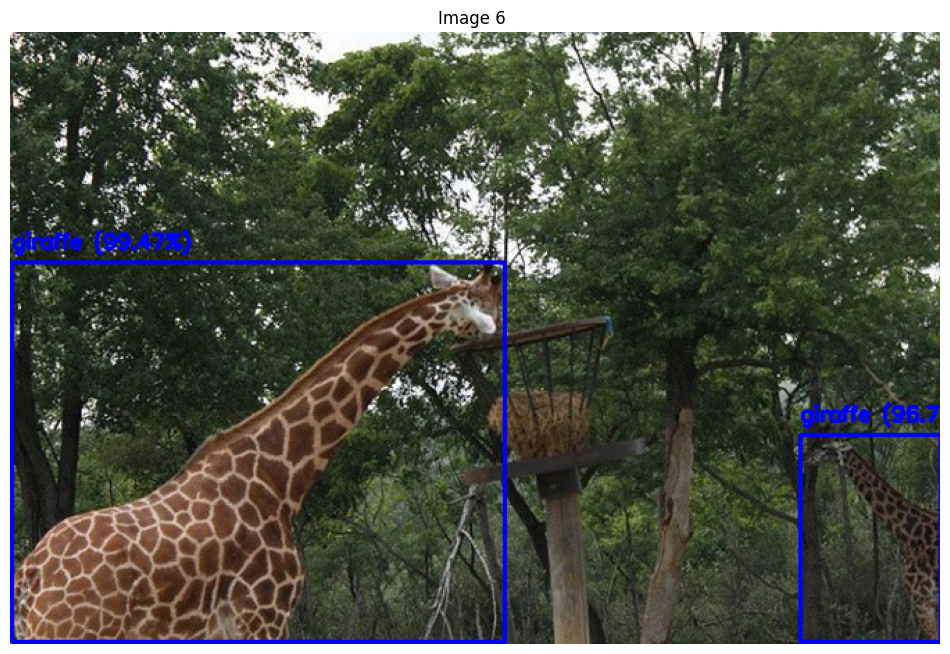

In [6]:
detector.loadModel()
input_images = ["output_images/g1.jpg", "output_images/g2.jpg", "output_images/g3.jpg", "output_images/g4.jpg", "output_images/g5.jpg","output_images/g6.jpg"]
# input_images=["Downloads/TV/tv2.jpg","Downloads/TV/tv3.jpg","Downloads/TV/tv4.jpg","Downloads/TV/tv5.jpg","Downloads/TV/tv6.jpg"]
# input_images=["Downloads/CLOCK/clock 1.jpg","Downloads/CLOCK/clock 2.jpg","Downloads/CLOCK/clock 5.jpg","Downloads/CLOCK/clock3.jpg"]
final_detections, bounding_boxes, all_class_probabilities = process_images(input_images, detector, coco_labels)

In [7]:
mapped_detections = []

for image_detections, image_bounding_boxes in zip(final_detections, bounding_boxes):
    image_mapped_info = []

    for label, bbox in zip(image_detections, image_bounding_boxes):
        image_mapped_info.append({
            "label": label,
            "bounding_box": bbox
        })

    mapped_detections.append(image_mapped_info)

for i, mapped in enumerate(mapped_detections):
    print(f"Image {i + 1} Mapped Detections:")
    for detection in mapped:
        print(f"Label: {detection['label']}, Bounding Box: {detection['bounding_box']}")
    print("\n")

Image 1 Mapped Detections:
Label: giraffe, Bounding Box: [284, 177, 541, 446]
Label: person, Bounding Box: [73, 82, 268, 445]
Label: giraffe, Bounding Box: [264, 128, 482, 382]
Label: person, Bounding Box: [62, 191, 76, 226]


Image 2 Mapped Detections:
Label: giraffe, Bounding Box: [197, 71, 507, 418]
Label: giraffe, Bounding Box: [124, 95, 387, 422]
Label: giraffe, Bounding Box: [563, 91, 630, 161]


Image 3 Mapped Detections:
Label: giraffe, Bounding Box: [321, 3, 598, 186]
Label: person, Bounding Box: [83, 180, 314, 440]
Label: person, Bounding Box: [344, 302, 406, 443]
Label: person, Bounding Box: [248, 337, 312, 443]
Label: person, Bounding Box: [313, 228, 368, 355]
Label: person, Bounding Box: [296, 301, 354, 442]
Label: person, Bounding Box: [285, 245, 327, 333]


Image 4 Mapped Detections:
Label: giraffe, Bounding Box: [7, 68, 291, 434]


Image 5 Mapped Detections:
Label: giraffe, Bounding Box: [392, 84, 592, 413]
Label: giraffe, Bounding Box: [88, 131, 267, 382]
Label: giraff

# FEATURE EXTRACTION

In [8]:
import os
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import preprocess_input
import cv2


final_features =  [[] for _ in range(len(input_images))]


for image_index, image_path in enumerate(input_images):
    features = []
    if os.path.exists(image_path):
        full_img = load_img(image_path)
        full_img_array = img_to_array(full_img)

        if image_index < len(mapped_detections):
            image_mapped_info = mapped_detections[image_index]

            for detection in image_mapped_info:
                label = detection['label']
                bbox = detection['bounding_box']
                x_min, y_min, x_max, y_max = bbox

                cropped_region = full_img_array[y_min:y_max, x_min:x_max]

                cropped_region_resized = cv2.resize(cropped_region, (224, 224))
                cropped_region_resized = preprocess_input(cropped_region_resized)
                cropped_region_resized = np.expand_dims(cropped_region_resized, axis=0)

                feature = model.predict(cropped_region_resized, verbose=0)

                features.append({
                    "label": label,
                    "bounding_box": bbox,
                    "feature_vector": feature
                })
        final_features[image_index] = features
max_detections = max(len(features) for features in final_features)
feature_vector_size = 4096

features_array = np.zeros((len(input_images), max_detections, feature_vector_size))
bounding_box = np.zeros((len(input_images), max_detections, 4))
for i, features in enumerate(final_features):
    for j, f in enumerate(features):
        features_array[i, j] = f["feature_vector"].flatten()
        bounding_box[i, j] = f['bounding_box']

for image_features in final_features:
    for f in image_features:
        print(f"Label: {f['label']}, Bounding Box: {f['bounding_box']}, Feature Vector Shape: {f['feature_vector'].shape}")

print(f"Features Array Shape: {features_array.shape}")
print(features_array)


C:\Users\KHUSHI\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


Label: giraffe, Bounding Box: [284, 177, 541, 446], Feature Vector Shape: (1, 4096)
Label: person, Bounding Box: [73, 82, 268, 445], Feature Vector Shape: (1, 4096)
Label: giraffe, Bounding Box: [264, 128, 482, 382], Feature Vector Shape: (1, 4096)
Label: person, Bounding Box: [62, 191, 76, 226], Feature Vector Shape: (1, 4096)
Label: giraffe, Bounding Box: [197, 71, 507, 418], Feature Vector Shape: (1, 4096)
Label: giraffe, Bounding Box: [124, 95, 387, 422], Feature Vector Shape: (1, 4096)
Label: giraffe, Bounding Box: [563, 91, 630, 161], Feature Vector Shape: (1, 4096)
Label: giraffe, Bounding Box: [321, 3, 598, 186], Feature Vector Shape: (1, 4096)
Label: person, Bounding Box: [83, 180, 314, 440], Feature Vector Shape: (1, 4096)
Label: person, Bounding Box: [344, 302, 406, 443], Feature Vector Shape: (1, 4096)
Label: person, Bounding Box: [248, 337, 312, 443], Feature Vector Shape: (1, 4096)
Label: person, Bounding Box: [313, 228, 368, 355], Feature Vector Shape: (1, 4096)
Label: p

In [10]:
import cv2
import matplotlib.pyplot as plt


all_class_probabilities = []
# input_images = ["val2014/COCO_val2014_000000581100.jpg", "val2014\COCO_val2014_000000581929.jpg"]
final_detections = [[] for _ in range(len(input_images))]
bounding_boxes = [[] for _ in range(len(input_images))]
all_image_class_probabilities = []

detector.loadModel()

for i, input_image in enumerate(input_images):
    detections = detector.detectObjectsFromImage(
        input_image=input_image,
        output_image_path="/content/detected/detected_objects.jpg",
        extract_detected_objects=False
    )

    for detection in detections:

        detected_class = detection["name"]
        detected_probability = detection["percentage_probability"]
        box_points = detection["box_points"]
        final_detections[i].append(detected_class)
        bounding_boxes[i].append(box_points)
        print(f"Detected: {detected_class} | Probability: {detected_probability} | Box: {box_points}")
        image_class_probabilities = []

        for detection in detections:
            detected_class = detection["name"]
            detected_probability = detection["percentage_probability"]
            class_prob_vector = [0] * len(coco_labels)

            if detected_class in coco_labels:
                class_prob_vector[coco_labels.index(detected_class)] = detected_probability

            image_class_probabilities.append(class_prob_vector)

    all_class_probabilities.append(image_class_probabilities)
    output_image = cv2.imread("/content/detected_objects.jpg")

    # plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()

print("Final Detections:", final_detections)
print("Bounding Boxes:", bounding_boxes)

Detected: giraffe | Probability: 96.99 | Box: [284, 177, 541, 446]
Detected: person | Probability: 95.91 | Box: [73, 82, 268, 445]
Detected: giraffe | Probability: 74.16 | Box: [264, 128, 482, 382]
Detected: person | Probability: 72.43 | Box: [62, 191, 76, 226]
Detected: giraffe | Probability: 99.67 | Box: [197, 71, 507, 418]
Detected: giraffe | Probability: 94.6 | Box: [124, 95, 387, 422]
Detected: giraffe | Probability: 87.16 | Box: [563, 91, 630, 161]
Detected: giraffe | Probability: 90.54 | Box: [321, 3, 598, 186]
Detected: person | Probability: 84.37 | Box: [83, 180, 314, 440]
Detected: person | Probability: 72.79 | Box: [344, 302, 406, 443]
Detected: person | Probability: 63.29 | Box: [248, 337, 312, 443]
Detected: person | Probability: 60.82 | Box: [313, 228, 368, 355]
Detected: person | Probability: 56.87 | Box: [296, 301, 354, 442]
Detected: person | Probability: 53.77 | Box: [285, 245, 327, 333]
Detected: giraffe | Probability: 97.84 | Box: [7, 68, 291, 434]
Detected: giraffe

# OBJECT CONTEXT CONSTRUCTION

In [11]:
import torch
import torch.nn as nn
import numpy as np

class ObjectContextConstruction(nn.Module):
    def __init__(self, num_classes, hidden_dim=512, embedding_dim=300, feature_dim=4096):
        super(ObjectContextConstruction, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.feature_dim = feature_dim  # Adjusted feature dimension
        
        # Embedding layer for object labels
        self.label_embedding = nn.Linear(num_classes, embedding_dim)
        
        # BiLSTM for context construction
        self.bilstm = nn.LSTM(
            input_size=embedding_dim + feature_dim,  # Use feature_dim (4096) here
            hidden_size=hidden_dim,
            bidirectional=True,
            batch_first=True
        )
        
        # LSTM for class label decoding
        self.decoder_lstm = nn.LSTM(
            input_size=hidden_dim*2 + num_classes,  # *2 because bidirectional
            hidden_size=hidden_dim,
            batch_first=True
        )
        
        # Output layer for class prediction
        self.class_predictor = nn.Linear(hidden_dim, num_classes)
        
        # Parameter matrices mentioned in the paper
        self.W1 = nn.Parameter(torch.randn(num_classes, embedding_dim))
        self.Wo = nn.Parameter(torch.randn(hidden_dim, num_classes))

    def construct_object_context(self, features, label_probabilities, bounding_boxes):
        """
        Constructs contextualized representations of objects
        
        Args:
            features (list): List of feature vectors from object detection
            label_probabilities (list): List of class probability vectors
            bounding_boxes (list): List of bounding box coordinates
        
        Returns:
            tuple: (object_contexts, predicted_labels)
        """
        # Convert inputs to tensors
        features = torch.FloatTensor(features)
        label_probs = torch.FloatTensor(label_probabilities)
        
        # Sort by bounding box locations (left to right, top to bottom)
        boxes = torch.FloatTensor(bounding_boxes)
        _, sorted_indices = torch.sort(boxes[:, 0] + boxes[:, 1])
        
        features = features[sorted_indices]
        label_probs = label_probs[sorted_indices]
        
        # Embed label probabilities
        print(label_probs.shape)
        label_embedding = torch.matmul(label_probs, self.W1)
        
        # Concatenate features and label embeddings (now 4096 + 300 = 4396)
        combined_features = torch.cat([features, label_embedding], dim=-1)
        
        # Verify the shape of combined features
        assert combined_features.size(-1) == 4396, f"Expected 4396, but got {combined_features.size(-1)}"
        
        # Pass through BiLSTM
        object_contexts, _ = self.bilstm(combined_features.unsqueeze(0))
        object_contexts = object_contexts.squeeze(0)
        print(object_contexts)
        print(len(object_contexts))
        # Decode class labels
        predicted_labels = []
        hidden = None
        
        for i in range(len(object_contexts)):
            if i == 0:
                prev_label = torch.zeros(self.num_classes)
            else:
                prev_label = predicted_labels[-1]
            print(len(object_contexts[i]))  
            print(prev_label)
            lstm_input = torch.cat([object_contexts[i], prev_label])
            output, hidden = self.decoder_lstm(lstm_input.unsqueeze(0).unsqueeze(0), hidden)
            
            # Predict class label
            class_scores = torch.matmul(output.squeeze(0).squeeze(0), self.Wo)
            predicted_label = torch.nn.functional.one_hot(
                torch.argmax(class_scores), 
                num_classes=self.num_classes
            )
            predicted_labels.append(predicted_label)
            
        predicted_labels = torch.stack(predicted_labels)
        
        return object_contexts, predicted_labels


def process_detections(final_detections, bounding_boxes, all_class_probabilities, features_array):
    """
    Process the detections from multiple images to create input for context construction
    
    Args:
        final_detections (list): List of detected objects per image
        bounding_boxes (list): List of bounding boxes per image
        all_class_probabilities (list): List of class probabilities per image
        feature_extractor: CNN feature extractor (e.g., ResNet)
        
    Returns:
        tuple: (combined_features, combined_probs, combined_boxes)
    """
    combined_features = []
    combined_probs = []
    combined_boxes = []
    
    for i in range(len(final_detections)):
        print(final_detections[i])
        image_features = features_array[i]
        combined_features.extend(image_features)
        combined_probs.extend(all_class_probabilities[i])
        combined_boxes.extend(bounding_boxes[i])
    
    return combined_features, combined_probs, combined_boxes

# Usage example:

# Initialize the context construction model
num_classes = len(coco_labels)  # Number of COCO classes
context_model = ObjectContextConstruction(num_classes=num_classes)

# Process detections from multiple images
combined_features, combined_probs, combined_boxes = process_detections(
    final_detections,
    bounding_boxes,
    all_class_probabilities,
    features_array  # You'll need to implement or use an existing feature extractor
)

print(len(combined_probs))
# Construct object contexts
object_contexts, predicted_labels = context_model.construct_object_context(
    combined_features,
    combined_probs,
    combined_boxes
)


['giraffe', 'person', 'giraffe', 'person']
['giraffe', 'giraffe', 'giraffe']
['giraffe', 'person', 'person', 'person', 'person', 'person', 'person']
['giraffe']
['giraffe', 'giraffe', 'giraffe', 'giraffe']
['giraffe', 'giraffe']
21
torch.Size([21, 80])


C:\Users\KHUSHI\AppData\Local\Temp\ipykernel_19132\777057201.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  features = torch.FloatTensor(features)


tensor([[ 1.4240e-12, -6.3584e-02,  7.5685e-01,  ..., -1.0000e+00,
         -2.5606e-19,  7.6242e-01],
        [ 9.6401e-01,  2.7738e-04,  5.9234e-02,  ..., -1.4587e-13,
         -9.9751e-01,  7.7389e-01],
        [ 2.4703e-12,  3.6891e-03,  7.8511e-01,  ..., -1.0000e+00,
         -6.8454e-18,  7.7389e-01],
        ...,
        [ 9.9999e-01,  4.5943e-01, -1.3125e-05,  ..., -6.2670e-11,
         -1.5338e-01,  7.6357e-01],
        [ 1.8733e-10, -7.1109e-03,  7.6076e-01,  ..., -8.3304e-25,
         -1.6851e-16,  7.6357e-01],
        [ 3.6797e-12,  8.2047e-04,  9.6358e-01,  ..., -1.4001e-27,
         -8.0904e-18,  7.6159e-01]], grad_fn=<SqueezeBackward1>)
21
1024
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 

In [12]:
import numpy as np


print(final_detections)
flattened_detections = [item for sublist in final_detections for item in sublist]

# Convert the flattened list to a 1D numpy array
final_detections_1d = np.array(flattened_detections)

# Print the resulting 1D array
print(final_detections_1d)
unique_detections = np.unique(final_detections_1d)

# Print the resulting array with unique values
print(unique_detections)

[['giraffe', 'person', 'giraffe', 'person'], ['giraffe', 'giraffe', 'giraffe'], ['giraffe', 'person', 'person', 'person', 'person', 'person', 'person'], ['giraffe'], ['giraffe', 'giraffe', 'giraffe', 'giraffe'], ['giraffe', 'giraffe']]
['giraffe' 'person' 'giraffe' 'person' 'giraffe' 'giraffe' 'giraffe'
 'giraffe' 'person' 'person' 'person' 'person' 'person' 'person' 'giraffe'
 'giraffe' 'giraffe' 'giraffe' 'giraffe' 'giraffe' 'giraffe']
['giraffe' 'person']


In [13]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
def generate_class_pairs(detections):
    class_pairs = set()
    unique_detections = set(detections)  # Get unique detections

    unique_list = list(unique_detections)  # Convert to list for indexing
    for i, x in enumerate(unique_list):
        for y in unique_list[i + 1:]:
            # print(x,y)
            class_pairs.add((x, y))
    return class_pairs

class_pairs = generate_class_pairs(final_detections_1d)
print(class_pairs)

{('giraffe', 'person')}


c:\Python312\Lib\threading.py:1016: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  del self._target, self._args, self._kwargs
c:\Python312\Lib\threading.py:1016: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  del self._target, self._args, self._kwargs
c:\Python312\Lib\threading.py:1016: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  del self._target, self._args, self._kwargs


# EXTERNAL KNOWLEDGE GRAPH INTEGRATION

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_sort_pool
import requests
import time
import numpy as np
from typing import Dict, List, Tuple

class KnowledgeGraphIntegration(nn.Module):
    def __init__(self, glove_path: str, embedding_dim: int = 300, hidden_dim: int = 512):
        super(KnowledgeGraphIntegration, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # Load GloVe embeddings
        self.word_to_vec = self._load_glove(glove_path)
        
        self.gcn1 = GCNConv(embedding_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
    
    def _load_glove(self, glove_path: str) -> Dict[str, np.ndarray]:
        """
        Load GloVe embeddings from file.
        Expected format: word v1 v2 ... v300
        """
        print("Loading GloVe embeddings...")
        word_to_vec = {}
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                if len(vector) == self.embedding_dim:
                    word_to_vec[word] = vector
        print(f"Loaded {len(word_to_vec)} word vectors")
        return word_to_vec
    
    def _get_word_embedding(self, word: str) -> np.ndarray:
        """
        Get GloVe embedding for a word. If word not found, use average of subwords
        or return zero vector as fallback.
        """
        word = word.lower().strip()
        if word in self.word_to_vec:
            return self.word_to_vec[word]
        
        # Try splitting compound words
        parts = word.split()
        if len(parts) > 1:
            vectors = []
            for part in parts:
                if part in self.word_to_vec:
                    vectors.append(self.word_to_vec[part])
            if vectors:
                return np.mean(vectors, axis=0)
        
        print(f"Warning: '{word}' not found in GloVe vocabulary")
        return np.zeros(self.embedding_dim)
        
    def build_knowledge_graph(self, class_pair: Tuple[str, str]) -> Tuple[torch.Tensor, torch.Tensor]:
        x, y = class_pair
        relations = ["RelatedTo", "SimilarTo", "Synonym"]
        nodes = set([x, y])
        edges = []
        
        print(f"\nBuilding knowledge graph for {x} and {y}")
        
        # Add self-loops for initial nodes
        edges.append((x, x))
        edges.append((y, y))
        
        for relation in relations:
            urls = [
                f"http://api.conceptnet.io/query?node=/c/en/{x}&other=/c/en/{y}&rel=/r/{relation}",
                f"http://api.conceptnet.io/query?node=/c/en/{y}&other=/c/en/{x}&rel=/r/{relation}"
            ]
            
            for url in urls:
                try:
                    response = requests.get(url).json()
                    time.sleep(0.1)  # Rate limiting
                    
                    print(f"Found {len(response.get('edges', []))} edges for relation {relation}")
                    
                    for edge in response.get("edges", []):
                        start = edge["start"]["label"].lower()
                        end = edge["end"]["label"].lower()
                        nodes.add(start)
                        nodes.add(end)
                        edges.append((start, end))
                        edges.append((end, start))
                except Exception as e:
                    print(f"Error querying ConceptNet: {str(e)}")
        
        if len(edges) <= 2:
            print("No relationships found, creating minimal connected graph")
            edges.append((x, y))
            edges.append((y, x))
        
        # Convert to numeric indices and get GloVe embeddings
        node_to_idx = {node: idx for idx, node in enumerate(nodes)}
        edge_list = [[node_to_idx[s], node_to_idx[t]] for s, t in edges]
        
        # Create node features using GloVe
        node_features = []
        for node in nodes:
            embedding = self._get_word_embedding(node)
            node_features.append(embedding)
        
        print(f"Final graph has {len(nodes)} nodes and {len(edge_list)} edges")
        
        edge_index = torch.tensor(edge_list, dtype=torch.long).t()
        node_features = torch.tensor(node_features, dtype=torch.float32)
        
        return edge_index, node_features
        
    def forward(self, class_pair):
        edge_index, node_features = self.build_knowledge_graph(class_pair)
        
        batch = torch.zeros(node_features.size(0), dtype=torch.long)
        
        x = F.relu(self.gcn1(node_features, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        
        pooled = global_sort_pool(x, batch, 1)
        return pooled

def test_knowledge_graph(glove_path: str):
    model = KnowledgeGraphIntegration(glove_path)
    

    
    results = {}
    for pair in class_pairs:
        try:
            print(f"\nProcessing pair: {pair}")
            embedding = model(pair)
            results[pair] = {
                "shape": embedding.shape,
                "preview": embedding[:5].tolist()
            }
        except Exception as e:
            print(f"Error processing pair {pair}: {str(e)}")
            results[pair] = f"Error: {str(e)}"
    
    for pair, result in results.items():
        print(f"\nResults for pair {pair}:")
        print(result)
    
    return results

if __name__ == "__main__":
    # glove_path = "Downloads/glove.6B.300d.txt"  # Update with your GloVe file path
    glove_path = "glove.6B.300d.txt"  # Update with your GloVe file path

    test_knowledge_graph(glove_path)

C:\Users\KHUSHI\AppData\Roaming\Python\Python312\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\KHUSHI\AppData\Roaming\Python\Python312\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\KHUSHI\AppData\Roaming\Python\Python312\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
C:\Users\KHUSHI\AppData\Roaming\Python\Pytho

Loading GloVe embeddings...
Loaded 400001 word vectors

Processing pair: ('giraffe', 'person')

Building knowledge graph for giraffe and person
Found 0 edges for relation RelatedTo
Found 0 edges for relation RelatedTo
Found 0 edges for relation SimilarTo
Found 0 edges for relation SimilarTo
Found 0 edges for relation Synonym
Found 0 edges for relation Synonym
No relationships found, creating minimal connected graph
Final graph has 2 nodes and 4 edges

Results for pair ('giraffe', 'person'):
{'shape': torch.Size([1, 512]), 'preview': [[0.05930022522807121, 0.0, 0.0, 0.0878751203417778, 0.0, 0.0422360934317112, 0.1346714198589325, 0.0, 0.02852819673717022, 0.0, 0.027285417541861534, 0.0, 0.0, 0.16312143206596375, 0.0, 0.1281343549489975, 0.0, 0.32229456305503845, 0.23761938512325287, 0.0, 0.012394539080560207, 0.16268973052501678, 0.07754883170127869, 0.0, 0.0, 0.0, 0.013556302525103092, 0.11023254692554474, 0.18135705590248108, 0.003186239628121257, 0.045304108411073685, 0.2488446086645

C:\Users\KHUSHI\AppData\Roaming\Python\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.global_sort_pool' is deprecated, use 'nn.aggr.SortAggr' instead
  warnings.warn(out)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RelationPredictor(nn.Module):
    def __init__(self, num_classes=80, hidden_dim=512, embedding_dim=300):
        super(RelationPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes  # Changed to 80 for COCO
        
        # Add class projection layer that was missing
        self.class_projection = nn.Linear(num_classes, hidden_dim)
        
        # BiLSTM for edge context
        self.edge_bilstm = nn.LSTM(
            input_size=hidden_dim*3,  # object context + projected class
            hidden_size=hidden_dim,
            bidirectional=True,
            batch_first=True
        )
        
        # Parameters for relation prediction
        self.W_h = nn.Linear(hidden_dim*2, hidden_dim)
        self.W_t = nn.Linear(hidden_dim*2, hidden_dim)
        self.W_r = nn.Linear(hidden_dim + embedding_dim, num_classes)  # +embedding_dim for knowledge
        self.W_2 = nn.Parameter(torch.randn(num_classes, hidden_dim))
        
        # Optional: Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights for better training stability"""
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
    
    def forward(self, object_contexts, predicted_labels, knowledge_integration):
        """
        Predict relationships between objects
        
        Args:
            object_contexts (torch.Tensor): Contextualized object representations [num_objects, hidden_dim*2]
            predicted_labels (torch.Tensor): One-hot encoded object labels [num_objects, num_classes]
            knowledge_integration (KnowledgeGraphIntegration): Knowledge graph module
            
        Returns:
            list: List of tuples (subject_idx, object_idx, relationship_probabilities)
        """
        # Project class labels to lower dimension
        projected_labels = self.class_projection(predicted_labels.float())
        
        # Combine object contexts and projected labels
        edge_input = torch.cat([
            object_contexts,  # [num_objects, hidden_dim*2]
            projected_labels  # [num_objects, hidden_dim]
        ], dim=-1)
        
        # Process through BiLSTM
        edge_contexts, _ = self.edge_bilstm(edge_input.unsqueeze(0))
        edge_contexts = edge_contexts.squeeze(0)
        
        # Predict relationships for all pairs
        num_objects = len(object_contexts)
        relationships = []
        
        # Get COCO class mapping
        coco_classes = self._get_coco_classes()
        
        for i in range(num_objects):
            for j in range(num_objects):
                if i != j:  # Don't predict self-relationships
                    try:
                        # Get class names for knowledge graph
                        class_i = torch.argmax(predicted_labels[i]).item()
                        class_j = torch.argmax(predicted_labels[j]).item()
                        
                        # Convert class indices to names
                        class_name_i = coco_classes[class_i]
                        class_name_j = coco_classes[class_j]
                        
                        # Get knowledge embedding for class pair
                        knowledge_embed = knowledge_integration((class_name_i, class_name_j))
                        
                        # Compute relationship score
                        head_repr = self.W_h(edge_contexts[i])
                        tail_repr = self.W_t(edge_contexts[j])
                        
                        # Compute union feature using actual object representations
                        union_feature = (head_repr + tail_repr) / 2  # Simple average pooling
                        
                        # Combine all features
                        relation_feature = head_repr * tail_repr * union_feature
                        combined_feature = torch.cat([relation_feature, knowledge_embed.squeeze(0)], dim=-1)
                        
                        # Predict relationship
                        relationship = self.W_r(combined_feature)
                        relationship = F.softmax(relationship, dim=-1)
                        
                        relationships.append((i, j, relationship))
                        
                    except Exception as e:
                        print(f"Error processing relationship between {class_name_i} and {class_name_j}: {str(e)}")
                        continue
        
        return relationships
    
    def _get_coco_classes(self):
        """Return list of COCO class names"""
        return [
            'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 
            'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 
            'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 
            'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
            'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 
            'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 
            'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 
            'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
            'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 
            'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 
            'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 
            'toothbrush'
        ]

# Example usage
class KnowledgeGraphIntegration:
    def __init__(self, embedding_dim=300):
        self.embedding_dim = embedding_dim
    
    def __call__(self, class_pair):
        # Dummy knowledge embedding - in practice, this would query a knowledge graph
        return torch.randn(1, self.embedding_dim)

def test_relation_predictor():
    num_classes = 80  # COCO dataset
    hidden_dim = 512
    embedding_dim = 300
    num_test_objects = 3
    
    # Initialize models
    knowledge_integration = KnowledgeGraphIntegration(embedding_dim=embedding_dim)
    relation_predictor = RelationPredictor(num_classes=num_classes, 
                                         hidden_dim=hidden_dim,
                                         embedding_dim=embedding_dim)
    
    # Create dummy input data

    print(object_contexts.shape)
    print(predicted_labels.shape)
    # Get predictions
    relationships = relation_predictor(object_contexts, 
                                       predicted_labels, knowledge_integration)
    
    # Print results
    coco_classes = relation_predictor._get_coco_classes()
    for i, j, rel in relationships:
        subject_class = coco_classes[torch.argmax(predicted_labels[i]).item()]
        object_class = coco_classes[torch.argmax(predicted_labels[j]).item()]
        top_rel_idx = torch.argmax(rel).item()
        top_rel_idx/=100
        print(f"Relationship: {subject_class} -> {object_class}, Score: {top_rel_idx}")
    
    return relationships

if __name__ == "__main__":
    test_relation_predictor()

torch.Size([21, 1024])
torch.Size([21, 80])
Relationship: giraffe -> person, Score: 0.47
Relationship: giraffe -> giraffe, Score: 0.4
Relationship: giraffe -> person, Score: 0.76
Relationship: giraffe -> giraffe, Score: 0.71
Relationship: giraffe -> giraffe, Score: 0.61
Relationship: giraffe -> giraffe, Score: 0.23
Relationship: giraffe -> giraffe, Score: 0.78
Relationship: giraffe -> person, Score: 0.66
Relationship: giraffe -> person, Score: 0.21
Relationship: giraffe -> person, Score: 0.28
Relationship: giraffe -> person, Score: 0.08
Relationship: giraffe -> person, Score: 0.64
Relationship: giraffe -> person, Score: 0.79
Relationship: giraffe -> giraffe, Score: 0.15
Relationship: giraffe -> giraffe, Score: 0.67
Relationship: giraffe -> giraffe, Score: 0.18
Relationship: giraffe -> giraffe, Score: 0.57
Relationship: giraffe -> giraffe, Score: 0.08
Relationship: giraffe -> giraffe, Score: 0.73
Relationship: giraffe -> giraffe, Score: 0.6
Relationship: person -> giraffe, Score: 0.55
R

# RELATION PREDICTION USING ATTENTION MECHANISM

In [ ]:
import ijson
import pandas as pd

# Initialize an empty list to hold the extracted data
data = []

# Path to your JSON file
json_file_path = 'relationships.json'

# Open the file and parse using ijson
with open(json_file_path, 'r') as file:
    parser = ijson.parse(file)
    current_predicate = None
    current_object_name = None
    current_subject_name = None
    for prefix, event, value in parser:
        # Detect the predicate name
        if prefix.endswith('.predicate') and event == 'string':
            current_predicate = value
        # Detect the subject name
        elif prefix.endswith('.subject.name') and event == 'string':
            current_subject_name = value
        # Detect the object name
        elif prefix.endswith('.object.name') and event == 'string':
            current_object_name = value
        # When we reach the end of the relationship, save the data
        elif prefix.endswith('item') and event == 'end_map':
            if current_predicate and current_subject_name and current_object_name:
                data.append({
                    'predicate': current_predicate,
                    'subject_name': current_subject_name,
                    'object_name': current_object_name
                })
            # Reset for the next relationship item
            current_predicate = None
            current_object_name = None
            current_subject_name = None

# Convert the extracted data into a DataFrame
df = pd.DataFrame(data)
print(df.head())


  predicate subject_name object_name
0       has          car   headlight
1        ON         sign    building
2        ON   tree trunk    sidewalk
3       has          man       shirt
4   next to     sidewalk      street


In [ ]:
filtered_df = df[df['subject_name'].isin(coco_labels) & df['object_name'].isin(coco_labels)]

# Display the filtered DataFrame
print(filtered_df)

             predicate subject_name object_name
59             next to        mouse    keyboard
61             next to        mouse    keyboard
101                 ON   teddy bear       couch
258            next to        mouse    keyboard
687                 ON       person       chair
...                ...          ...         ...
1737774           near        sheep       sheep
1737782           with        sheep       sheep
1737786  standing near        sheep       sheep
1737787  standing near        sheep       sheep
1737790           near        sheep       sheep

[26864 rows x 3 columns]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

relationship_df =filtered_df


# Define the Attention Layer
class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # x is a tensor of shape (batch_size, num_objects, embed_dim)
        Q = self.query(x)  # (batch_size, num_objects, embed_dim)
        K = self.key(x)    # (batch_size, num_objects, embed_dim)
        V = self.value(x)  # (batch_size, num_objects, embed_dim)

        # Compute attention scores
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (x.size(-1) ** 0.5)  # (batch_size, num_objects, num_objects)
        attention_weights = self.softmax(attention_scores)  # (batch_size, num_objects, num_objects)

        # Weighted sum of values
        attention_output = torch.matmul(attention_weights, V)  # (batch_size, num_objects, embed_dim)
        return attention_output, attention_weights


# Function to load GloVe embeddings from the file
def load_glove_embeddings(file_path):
    glove_embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = torch.tensor([float(val) for val in parts[1:]])  # Convert string values to float and create tensor
            glove_embeddings[word] = vector
    return glove_embeddings


# Load GloVe embeddings
glove_file_path = 'Downloads/glove.6B.300d.txt'  # Change this to the path of your glove file
glove_file_path = 'glove.6B.300d.txt'  # Change this to the path of your glove file

glove_embeddings = load_glove_embeddings(glove_file_path)

# Define the final detections (from your example)


# Initialize the Attention Layer
embed_dim = 300  # GloVe vectors have 300 dimensions
attention_layer = SelfAttention(embed_dim=embed_dim)

# Simulate the relationship embeddings for each detected pair
relationship_embeddings = []

# Process each image
for i, detections in enumerate(final_detections):
    # Get GloVe embeddings for the detections
    detection_embeddings = []
    for label in detections:
        embedding = glove_embeddings.get(label, torch.zeros(embed_dim))  # Use zero vector if not found
        detection_embeddings.append(embedding)
    
    detection_embeddings = torch.stack(detection_embeddings)  # (num_objects, embed_dim)

    # Apply self-attention to the detection embeddings
    attention_output, attention_weights = attention_layer(detection_embeddings.unsqueeze(0))  # Add batch dimension

    # Store the relationships with their attention-enhanced embeddings
    enhanced_relationships = []
    for j, subject in enumerate(detections):
        for k, obj in enumerate(detections):
            if j != k:
                # Assuming relationship_df is already defined
                match = relationship_df[
                    (relationship_df['subject_name'] == subject) & 
                    (relationship_df['object_name'] == obj)
                ]
                
                # If a relationship exists, store it with enhanced embeddings
                if not match.empty:
                    predicate = match.iloc[0]['predicate']
                    relationship = {
                        'subject': subject,
                        'predicate': predicate,
                        'object': obj,
                        'subject_box': bounding_boxes[i][j],
                        'object_box': bounding_boxes[i][k],
                        'attention_embedding': attention_output[0][j]  # Get the attention-enhanced embedding
                    }
                    enhanced_relationships.append(relationship)
    
    relationship_embeddings.append(enhanced_relationships)

# Print relationships with attention-enhanced embeddings
relationship_embeddings = relationship_embeddings[:3]
for i, relationships in enumerate(relationship_embeddings):
    print(f"Enhanced Relationships in Image {i + 1}:")
    for relationship in relationships:
        print(relationship)


Enhanced Relationships in Image 1:
{'subject': 'giraffe', 'predicate': 'looking at', 'object': 'person', 'subject_box': [284, 177, 541, 446], 'object_box': [73, 82, 268, 445], 'attention_embedding': tensor([ 3.9190e-02, -1.5766e-01, -5.4270e-03,  1.6682e-01,  2.7603e-01,
         2.1331e-01,  1.4937e-01, -1.8887e-01, -3.1047e-01, -4.2616e-02,
         1.1558e-01, -2.6355e-02,  3.0105e-02, -9.7012e-02, -5.7355e-02,
        -2.5385e-03,  7.5577e-02, -1.8190e-01,  1.0848e-01, -2.5290e-01,
        -1.3840e-01,  3.8145e-02,  3.3259e-01, -8.3582e-02,  3.3366e-01,
        -1.2963e-01,  6.0518e-02, -4.1606e-02, -3.5486e-02, -9.8698e-03,
        -1.4270e-01, -1.4084e-01, -1.2779e-02,  5.5770e-02, -1.8020e-01,
         8.1617e-03,  2.0418e-02,  2.1872e-01, -5.2473e-02,  9.3688e-02,
         9.2293e-02,  1.8127e-01,  2.3708e-01, -1.8404e-01,  4.0711e-02,
        -2.8280e-01, -5.9490e-02, -2.2694e-01,  5.1198e-02, -2.8676e-02,
        -1.1147e-01, -1.5564e-01, -1.5007e-01,  6.9404e-02, -9.8726e-02

# SCENE GRAPH GENERATION

In [ ]:
import numpy as np
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

class MixedDirectedSceneGraphGenerator:
    def __init__(self):
        # Define spatial relationships (undirected)
        self.spatial_relationships = {
            'above': lambda box1, box2: box1[1] + box1[3] < box2[1] + (box2[3] * 0.5),
            'next_to': lambda box1, box2: abs((box1[0] + box1[2]/2) - (box2[0] + box2[2]/2)) < max(box1[2], box2[2]),
            'near': lambda box1, box2: self.calculate_iou(box1, box2) > 0.1
        }
        self.environment_relationships = {
            'jungle': {
                'tree': 'part_of',
                'potted plant': 'part_of',
                'bird': 'lives_in',
                'giraffe': 'lives_in',
                'elephant': 'lives_in',
                'zebra': 'lives_in',
                'monkey': 'lives_in',
                'person': 'in'
            },
          'hill': {
                'grass': 'part_of',
                'tree': 'growing_on',
                'sheep': 'grazes_on',
                'cow': 'grazes_on',
                'dog': 'playing_on',
                'horse': 'running_on',
                'person': 'hiking_on',
                'bird': 'flying_over',
                'flower': 'growing_on',
                'bush': 'growing_on',
                'goat': 'climbing_on',
                'cat': 'roaming_on',
                'rabbit': 'hopping_on',
                'bench': 'placed_on',
                'rock': 'part_of',
                'fence': 'surrounding',
                'potted plant': 'growing_on',
                'bicycle': 'parked_on',
                'motorcycle': 'parked_on'
            }
        }
        # Common interactions will be set using create_common_interactions()
        self.common_interactions = {
            # Person interactions with objects
            ('person', 'bicycle'): 'riding',
            ('person', 'car'): 'driving',
            ('person', 'motorcycle'): 'riding',
            ('person', 'sports ball'): 'playing with',
            ('person', 'chair'): 'sitting on',
            ('person', 'couch'): 'sitting on',
            ('person', 'bed'): 'lying on',
            ('person', 'dining table'): 'sitting at',
            ('person', 'laptop'): 'using',
            ('person', 'cell phone'): 'using',
            ('person', 'book'): 'reading',
            ('person', 'baseball bat'): 'holding',
            ('person', 'tennis racket'): 'holding',
            ('person', 'skateboard'): 'riding',
            ('person', 'surfboard'): 'riding',
            ('person', 'skis'): 'using',
            ('person', 'snowboard'): 'riding',
            ('person', 'kite'): 'flying',
            ('person', 'fork'): 'using',
            ('person', 'knife'): 'using',
            ('person', 'spoon'): 'using',
            ('person', 'bottle'): 'holding',
            ('person', 'wine glass'): 'holding',
            ('person', 'cup'): 'holding',
            ('person', 'frisbee'): 'throwing',
            ('person','giraffe'): 'watching',
            ('person','zebra'): 'watching',
            ('person','cake'): 'eating',
            ('person', 'broccoli') : 'eating',
            ('person', 'donut') : 'eating',
            ('person', 'pizza') : 'eating',
            ('person', 'sandwich') : 'eating',
            ('person', 'banana') : 'eating',
            ('person', 'apple') : 'eating',




            
            # Animal interactions
            ('dog', 'sports ball'): 'playing with',
            ('cat', 'chair'): 'sitting on',
            ('bird', 'tree'): 'perching on',
            ('horse', 'person'): 'carrying',
            
            # Object placement relationships
            ('laptop', 'dining table'): 'on',
            ('book', 'dining table'): 'on',
            ('cup', 'dining table'): 'on',
            ('bottle', 'dining table'): 'on',
            ('bowl', 'dining table'): 'on',
            ('laptop', 'bed'): 'on',
            ('remote', 'couch'): 'on',
            ('cell phone', 'dining table'): 'on',
            
            # Food-related interactions
            ('fork', 'dining table'): 'on',
            ('knife', 'dining table'): 'on',
            ('spoon', 'dining table'): 'on',
            ('bowl', 'dining table'): 'on',
            ('pizza', 'dining table'): 'on',
            ('sandwich', 'dining table'): 'on',
            ('hot dog', 'dining table'): 'on',
            ('cake', 'dining table'): 'on',
            
            # Electronics relationships
            ('mouse', 'laptop'): 'connected to',
            ('keyboard', 'laptop'): 'connected to',
            
            # Kitchen relationships
            ('bowl', 'sink'): 'in',
            ('fork', 'sink'): 'in',
            ('knife', 'sink'): 'in',
            ('spoon', 'sink'): 'in',
            
            # Furniture relationships
            ('teddy bear', 'bed'): 'on',
            ('book', 'couch'): 'on',
            ('remote', 'couch'): 'on',
            
            # Container relationships
            ('banana', 'bowl'): 'in',
            ('apple', 'bowl'): 'in',
            ('orange', 'bowl'): 'in',
            
            # Vehicle-road interactions
            ('car', 'traffic light'): 'stopped at',
            ('bicycle', 'traffic light'): 'stopped at',
            ('motorcycle', 'traffic light'): 'stopped at',
            ('bus', 'traffic light'): 'stopped at',
            ('truck', 'traffic light'): 'stopped at',
            
            # Sports equipment relationships
            ('baseball glove', 'baseball bat'): 'used with',
            ('sports ball', 'baseball glove'): 'caught by',
            
            # Bathroom items
            ('toothbrush', 'sink'): 'near',
            ('hair drier', 'sink'): 'near',
            
            # Decorative items
            ('vase', 'dining table'): 'on',
            ('potted plant', 'dining table'): 'on',
            
            # Clothing/accessory relationships
            ('tie', 'person'): 'worn by',
            ('backpack', 'person'): 'carried by',
            ('handbag', 'person'): 'carried by',
            ('umbrella', 'person'): 'carried by'

            



        }
        
    def calculate_iou(self, box1, box2):
        """Calculate Intersection over Union between two bounding boxes"""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[0] + box1[2], box2[0] + box2[2])
        y2 = min(box1[1] + box1[3], box2[1] + box2[3])
        
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = box1[2] * box1[3]
        area2 = box2[2] * box2[3]
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0
    
    def calculate_spatial_relationship_probability(self, box1, box2):
        """Calculate the probability of a spatial relationship based on bounding box size and overlap"""
        # Calculate the Intersection over Union (IoU) of the bounding boxes
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[0] + box1[2], box2[0] + box2[2])
        y2 = min(box1[1] + box1[3], box2[1] + box2[3])
        
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = box1[2] * box1[3]
        area2 = box2[2] * box2[3]
        union = area1 + area2 - intersection
        iou = intersection / union if union > 0 else 0
        
        # Calculate the probability based on bounding box size and IoU
        box1_area = box1[2] * box1[3]
        box2_area = box2[2] * box2[3]
        
        # Larger bounding boxes have a higher probability of spatial relationships
        probability = (box1_area + box2_area) / (area1 + area2) * iou
        
        return probability

    def get_relationship(self, box1, box2, obj1_class, obj2_class, obj1_prob, obj2_prob):
        # First check for semantic relationships (directed)
        if (obj1_class, obj2_class) in self.common_interactions:
            relationship = self.common_interactions[(obj1_class, obj2_class)]
            directed = True
            probability = obj1_prob * obj2_prob
        elif (obj2_class, obj1_class) in self.common_interactions:
            relationship = self.common_interactions[(obj2_class, obj1_class)]
            directed = True
            probability = obj2_prob * obj1_prob
        else:
            # If no semantic relationship, check spatial relationships (undirected)
            for rel_name, rel_func in self.spatial_relationships.items():
                if rel_func(box1, box2):
                    relationship = rel_name
                    directed = False
                    probability = self.calculate_spatial_relationship_probability(box1, box2) + 0.4
                    break
            else:
                relationship = 'near'
                directed = False
                probability = self.calculate_spatial_relationship_probability(box1, box2) +0.4

        return relationship, directed, probability
    def generate_scene_graph(self, detections, boxes, all_class_probabilities, environment=None):
        """Generate mixed directed/undirected scene graph with support for multiple instances"""
        nodes = []
        edges = []
        
        # Add environment node if specified
        env_node_id = None
        if environment in ["jungle", "hill"]:
            env_node_id = len(nodes)
            nodes.append({
                'id': env_node_id,
                'class': environment,
                'instance_id': 0,  # Environment is always single instance
                'box': None
            })

        # Create instance counters for each class
        instance_counters = {}
        
        # Create nodes for each detected object with unique instance IDs
        for i, (obj_class, box, obj_prob) in enumerate(zip(detections, boxes, all_class_probabilities)):
            # Increment instance counter for this class
            if obj_class not in instance_counters:
                instance_counters[obj_class] = 0
            else:
                instance_counters[obj_class] += 1
                    
            node_id = len(nodes)
            nodes.append({
                'id': node_id,
                'class': obj_class,
                'instance_id': instance_counters[obj_class],
                'box': box,
                'probability': obj_prob
            })
            
            # Add environment relationships if applicable
            if env_node_id is not None and obj_class in self.environment_relationships.get(environment, {}):
                edges.append({
                    'subject': node_id,
                    'object': env_node_id,
                    'relationship': self.environment_relationships[environment][obj_class],
                    'directed': True
                })
        
        # Create edges between objects
        processed_pairs = set()
        for i, node1 in enumerate(nodes):
            for j, node2 in enumerate(nodes):
                if i != j and (i, j) not in processed_pairs and (j, i) not in processed_pairs:
                    if node1.get('box') is not None and node2.get('box') is not None:
                        try:
                            relationship, directed, probability = self.get_relationship(
                                node1['box'], node2['box'], node1['class'], node2['class'],
                                node1['probability'], node2['probability']
                            )
                            if directed:
                                edges.append({
                                    'subject': node1['id'],
                                    'object': node2['id'],
                                    'relationship': relationship,
                                    'directed': True,
                                    'probability': probability
                                })
                            else:
                                edges.append({
                                    'subject': node1['id'],
                                    'object': node2['id'],
                                    'relationship': relationship,
                                    'directed': False,
                                    'probability': probability
                                })
                            processed_pairs.add((i, j))
                        except Exception as e:
                            print(f"Error processing relationship between {node1['class']} and {node2['class']}: {e}")
        
        return {'nodes': nodes, 'edges': edges}

# Visualization function remains the same
def visualize_mixed_scene_graph(scene_graph):
        """Visualize the mixed directed/undirected scene graph"""
        G = nx.MultiDiGraph()
        
        # Add nodes
        for node in scene_graph['nodes']:
            # Add special styling for environment nodes
            if node['class'] == 'jungle':
                G.add_node(node['id'], label=node['class'], node_color='lightgreen', node_size=2500)
            else:
                G.add_node(node['id'], label=node['class'], node_color='lightblue', node_size=2000)
        
        # Add edges
        directed_edges = [(e['subject'], e['object']) for e in scene_graph['edges'] if e['directed']]
        undirected_edges = [(e['subject'], e['object']) for e in scene_graph['edges'] if not e['directed']]
        
        pos = nx.spring_layout(G, k=2, iterations=50)
        
        plt.figure(figsize=(15, 10))
        
        # Draw nodes with different colors for environment
        for node in G.nodes():
            nx.draw_networkx_nodes(G, pos,
                                nodelist=[node],
                                node_color=[G.nodes[node].get('node_color', 'lightblue')],
                                node_size=G.nodes[node].get('node_size', 2000),
                                node_shape='o')
        
        # Draw node labels
        nx.draw_networkx_labels(G, pos,
                            labels={node: G.nodes[node]['label'] for node in G.nodes()},
                            font_size=10,
                            font_weight='bold')
        
        # Draw directed edges
        directed_edge_labels = {(e['subject'], e['object']): e['relationship'] 
                            for e in scene_graph['edges'] if e['directed']}
        nx.draw_networkx_edges(G, pos,
                            edgelist=directed_edges,
                            edge_color='red',
                            arrows=True,
                            arrowsize=20,
                            width=2,
                            connectionstyle='arc3,rad=0.2')
        
        # Draw undirected edges
        undirected_edge_labels = {(e['subject'], e['object']): e['relationship'] 
                                for e in scene_graph['edges'] if not e['directed']}
        nx.draw_networkx_edges(G, pos,
                            edgelist=undirected_edges,
                            edge_color='gray',
                            arrows=False,
                            width=2,
                            style='solid')
        
        # Draw edge labels
        all_edge_labels = {**directed_edge_labels, **undirected_edge_labels}
        nx.draw_networkx_edge_labels(G, pos,
                                    edge_labels=all_edge_labels,
                                    font_size=8,
                                    label_pos=0.5)
        
        plt.title("Mixed Directed-Undirected Scene Graph with Environment", pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


In [ ]:
import cv2
import numpy as np
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

def is_natural_environment(image, detections):
    """
    Determine if the environment is natural based on detected objects
    Returns: "jungle" if jungle-like objects are detected, "hill" if hill-like objects are detected, None otherwise
    """
    natural_objects = {
        'jungle': ['tree', 'bird', 'giraffe', 'elephant', 'zebra', 'monkey'],
        'hill': ['grass', 'tree', 'sheep', 'cow', 'flower', 'rock']
    }
    
    detected_classes = [det['name'].lower() for det in detections]
    
    # Check for jungle environment
    jungle_matches = sum(1 for obj in detected_classes if obj in natural_objects['jungle'])
    if jungle_matches >= 2:  # If at least 2 jungle objects are detected
        return "jungle"
    
    # Check for hill environment
    hill_matches = sum(1 for obj in detected_classes if obj in natural_objects['hill'])
    if hill_matches >= 2:  # If at least 2 hill objects are detected
        return "hill"
    
    return None

def visualize_mixed_scene_graph_with_prob(scene_graph):
    """Visualize the mixed directed/undirected scene graph with probabilities"""
    G = nx.MultiDiGraph()
    
    # Add nodes
    for node in scene_graph['nodes']:
        # Add probability to node label if available
        label = f"{node['class']}\n({node.get('probability', 1.0):.2f})"
        if node['class'] in ['jungle', 'hill']:
            G.add_node(node['id'], label=label, node_color='lightgreen', node_size=2500)
        else:
            G.add_node(node['id'], label=label, node_color='lightblue', node_size=2000)
    
    # Separate directed and undirected edges
    directed_edges = [(e['subject'], e['object']) for e in scene_graph['edges'] if e['directed']]
    undirected_edges = [(e['subject'], e['object']) for e in scene_graph['edges'] if not e['directed']]
    
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    plt.figure(figsize=(15, 10))
    
    # Draw nodes
    for node in G.nodes():
        nx.draw_networkx_nodes(G, pos,
                            nodelist=[node],
                            node_color=[G.nodes[node].get('node_color', 'lightblue')],
                            node_size=G.nodes[node].get('node_size', 2000),
                            node_shape='o')
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos,
                          labels={node: G.nodes[node]['label'] for node in G.nodes()},
                          font_size=10,
                          font_weight='bold')
    
    # Draw directed edges with probabilities
    directed_edge_labels = {(e['subject'], e['object']): f"{e['relationship']}\n({e['probability']:.2f})"
                          for e in scene_graph['edges'] if e['directed']}
    nx.draw_networkx_edges(G, pos,
                          edgelist=directed_edges,
                          edge_color='red',
                          arrows=True,
                          arrowsize=20,
                          width=2,
                          connectionstyle='arc3,rad=0.2')
    
    # Draw undirected edges with probabilities
    undirected_edge_labels = {(e['subject'], e['object']): f"{e['relationship']}\n({e['probability']:.2f})"
                            for e in scene_graph['edges'] if not e['directed']}
    nx.draw_networkx_edges(G, pos,
                          edgelist=undirected_edges,
                          edge_color='gray',
                          arrows=False,
                          width=2,
                          style='solid')
    
    # Draw edge labels with probabilities
    all_edge_labels = {**directed_edge_labels, **undirected_edge_labels}
    nx.draw_networkx_edge_labels(G, pos,
                                edge_labels=all_edge_labels,
                                font_size=8,
                                label_pos=0.5)
    
    plt.title("Scene Graph with Relationship Probabilities", pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def process_images(input_images, detector):
    """
    Process multiple images and generate scene graphs
    """
    scene_graph_generator = MixedDirectedSceneGraphGenerator()
    scene_graphs = []
    
    for i, img_path in enumerate(input_images):
        try:
            # Load the image
            image = cv2.imread(img_path)
            if image is None:
                raise ValueError(f"Could not load image: {img_path}")
            
            # Perform object detection
            detections = detector.detectObjectsFromImage(input_image=img_path)
            
            # Extract required information from detections
            final_detections = []  # Classes
            bounding_boxes = []    # Boxes
            class_probabilities = []  # Probabilities
            
            for detection in detections:
                final_detections.append(detection['name'].lower())
                bounding_boxes.append([
                    detection['box_points'][0],  # x
                    detection['box_points'][1],  # y
                    detection['box_points'][2] - detection['box_points'][0],  # width
                    detection['box_points'][3] - detection['box_points'][1]   # height
                ])
                class_probabilities.append(detection['percentage_probability'] / 100.0)
            
            # Determine environment type
            environment = is_natural_environment(image, detections)
            
            # Generate scene graph
            scene_graph = scene_graph_generator.generate_scene_graph(
                detections=final_detections,
                boxes=bounding_boxes,
                all_class_probabilities=class_probabilities,
                environment=environment
            )
            
            scene_graphs.append(scene_graph)
            
            # Print the scene graph relationships with probabilities
            print(f"\nScene Graph for Image {i+1}:")
            print("Nodes:")
            for node in scene_graph['nodes']:
                prob_str = f" (probability: {node.get('probability', 1.0):.2f})" if 'probability' in node else ""
                print(f"  {node['id']}: {node['class']}{prob_str}")
            
            print("\nRelationships:")
            for edge in scene_graph['edges']:
                subject_node = next(n for n in scene_graph['nodes'] if n['id'] == edge['subject'])
                object_node = next(n for n in scene_graph['nodes'] if n['id'] == edge['object'])
                prob_str = f" (probability: {edge.get('probability', 1.0):.2f})"
                
                if edge['directed']:
                    print(f"  {subject_node['class']} --{edge['relationship']}--> {object_node['class']}{prob_str}")
                else:
                    print(f"  {subject_node['class']} -- {edge['relationship']} -- {object_node['class']}{prob_str}")
            
            # Visualize the scene graph with probabilities
            # visualize_mixed_scene_graph_with_prob(scene_graph)
            
        except Exception as e:
            print(f"Error processing image {i+1}: {str(e)}")
            continue
    
    return scene_graphs

In [ ]:
scene_graphs = process_images(input_images, detector)



Scene Graph for Image 1:
Nodes:
  0: jungle
  1: giraffe (probability: 0.97)
  2: person (probability: 0.96)
  3: giraffe (probability: 0.74)
  4: person (probability: 0.72)

Relationships:
  giraffe --lives_in--> jungle (probability: 1.00)
  person --in--> jungle (probability: 1.00)
  giraffe --lives_in--> jungle (probability: 1.00)
  person --in--> jungle (probability: 1.00)
  giraffe --watching--> person (probability: 0.93)
  giraffe -- next_to -- giraffe (probability: 0.88)
  giraffe --watching--> person (probability: 0.70)
  person --watching--> giraffe (probability: 0.71)
  person -- next_to -- person (probability: 0.40)
  giraffe --watching--> person (probability: 0.54)

Scene Graph for Image 2:
Nodes:
  0: jungle
  1: giraffe (probability: 1.00)
  2: giraffe (probability: 0.95)
  3: giraffe (probability: 0.87)

Relationships:
  giraffe --lives_in--> jungle (probability: 1.00)
  giraffe --lives_in--> jungle (probability: 1.00)
  giraffe --lives_in--> jungle (probability: 1.00)


In [ ]:
class SceneGraphMerger:
    def __init__(self):
        # Categories dictionary remains the same
        self.categories = {
            'animal': ['cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe'],
            'vehicle': ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat'],
            'person': ['person'],
            'furniture': ['chair', 'couch', 'bed', 'dining table', 'bench'],
            'electronics': ['tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone'],
            'kitchen': ['microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'bowl', 'cup'],
            'food': ['banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake'],
            'sports': ['frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 
                      'skateboard', 'surfboard', 'tennis racket'],
            'accessories': ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase'],
            'utensils': ['fork', 'knife', 'spoon'],
            'traffic': ['traffic light', 'fire hydrant', 'stop sign', 'parking meter']
        }
        
        # Enhanced animal anatomy with common and specific traits
        self.animal_anatomy = {
            'common_traits': {
                'has_legs': 4,
                'has_body': 1,
                'has_tail': 1
            },
            'specific_traits': {
                'elephant': {
                    'has_trunk': 1,
                    'has_tusks': 2
                }
            }
        }
        
        self.object_to_category = {}
        for category, objects in self.categories.items():
            for obj in objects:
                self.object_to_category[obj] = category

    def get_category(self, object_class):
        """Get the category for a given object class"""
        return self.object_to_category.get(object_class, 'other')

    def add_animal_anatomy_nodes(self, merged_nodes, merged_edges, animal_nodes):
        """
        Simplified version that creates a single traits node for both common and specific traits
        """
        anatomy_nodes = {}
        next_node_id = max(node['id'] for node in merged_nodes) + 1
        
        # Create the generic "Animal" node
        generic_animal_node = {
            'id': next_node_id,
            'class': 'Animal',
            'category': 'animal',
            'instances': []
        }
        merged_nodes.append(generic_animal_node)
        generic_animal_id = next_node_id
        next_node_id += 1
        
        # Add single traits node that will contain all traits
        traits_node = {
            'id': next_node_id,
            'class': 'Animal Traits',
            'category': 'traits',
            'instances': []
        }
        merged_nodes.append(traits_node)
        traits_id = next_node_id
        next_node_id += 1
        
        # Connect generic animal to traits node
        merged_edges.append({
            'subject': generic_animal_id,
            'object': traits_id,
            'relationship': 'has_traits',
            'directed': True
        })
        
        # Add common traits
        for trait, value in self.animal_anatomy['common_traits'].items():
            trait_node = {
                'id': next_node_id,
                'class': f"{trait} ({value})",
                'category': 'trait',
                'instances': []
            }
            merged_nodes.append(trait_node)
            merged_edges.append({
                'subject': traits_id,
                'object': next_node_id,
                'relationship': 'includes',
                'directed': True
            })
            next_node_id += 1
        
        # Process each specific animal
        for animal_node in animal_nodes:
            animal_class = animal_node['class'].lower()
            node_id = animal_node['id']
            
            # Connect specific animal to generic animal
            merged_edges.append({
                'subject': node_id,
                'object': generic_animal_id,
                'relationship': 'is_a',
                'directed': True
            })
            
            # Add specific traits if they exist
            if animal_class in self.animal_anatomy['specific_traits']:
                # Add each specific trait directly to the main traits node
                for trait, value in self.animal_anatomy['specific_traits'][animal_class].items():
                    trait_node = {
                        'id': next_node_id,
                        'class': f"{animal_class}_{trait} ({value})",
                        'category': 'trait',
                        'instances': []
                    }
                    merged_nodes.append(trait_node)
                    merged_edges.append({
                        'subject': traits_id,
                        'object': next_node_id,
                        'relationship': 'includes',
                        'directed': True
                    })
                    # Also connect the specific trait to its animal
                    merged_edges.append({
                        'subject': node_id,
                        'object': next_node_id,
                        'relationship': 'has_trait',
                        'directed': True
                    })
                    next_node_id += 1
        
        return merged_nodes, merged_edges
    
    def merge_scene_graphs(self, scene_graphs, abstraction_level='mixed'):
        """
        Merge multiple scene graphs with optional abstraction and add anatomical features for animals
        abstraction_level: 'none' (keep original), 'full' (all categorical), 'mixed' (merge same objects, categorize others)
        """
        merged_nodes = {}
        merged_edges = []
        node_id_counter = 0
        
        # First pass: Create nodes and build mapping
        node_mapping = {}
        for graph_idx, graph in enumerate(scene_graphs):
            for node in graph['nodes']:
                original_class = node['class']
                category = self.get_category(original_class)
                
                # Determine node class based on abstraction level
                if abstraction_level == 'none':
                    node_class = original_class
                elif abstraction_level == 'full':
                    node_class = category
                else:  # mixed
                    node_class = original_class
                
                # Create or get existing node
                node_key = f"{node_class}_{graph_idx}" if abstraction_level == 'none' else node_class
                
                if node_key not in merged_nodes:
                    merged_nodes[node_key] = {
                        'id': node_id_counter,
                        'class': node_class,
                        'category': category,
                        'instances': [{
                            'original_class': original_class,
                            'box': node['box'],
                            'graph_idx': graph_idx
                        }]
                    }
                    node_id_counter += 1
                else:
                    merged_nodes[node_key]['instances'].append({
                        'original_class': original_class,
                        'box': node['box'],
                        'graph_idx': graph_idx
                    })
                
                node_mapping[(graph_idx, node['id'])] = merged_nodes[node_key]['id']
        
        # Convert merged_nodes dictionary to list
        merged_nodes_list = list(merged_nodes.values())
        
        # Second pass: Create edges
        processed_edges = set()
        for graph_idx, graph in enumerate(scene_graphs):
            for edge in graph['edges']:
                new_subject_id = node_mapping[(graph_idx, edge['subject'])]
                new_object_id = node_mapping[(graph_idx, edge['object'])]
                
                edge_key = tuple(sorted([new_subject_id, new_object_id]))
                if edge_key not in processed_edges:
                    merged_edges.append({
                        'subject': new_subject_id,
                        'object': new_object_id,
                        'relationship': edge['relationship'],
                        'directed': edge['directed']
                    })
                    processed_edges.add(edge_key)
        
        # Collect all animal nodes
        animal_nodes = [node for node in merged_nodes_list if node['category'] == 'animal']
        
        # Add anatomical features for animals if any exist
        if animal_nodes:
            merged_nodes_list, merged_edges = self.add_animal_anatomy_nodes(merged_nodes_list, merged_edges, animal_nodes)
        
        return {
            'nodes': merged_nodes_list,
            'edges': merged_edges
        }

    def visualize_merged_scene_graph(self, merged_graph):
        """Enhanced visualization with better layout and colors for hierarchy"""
        G = nx.MultiDiGraph()
        
        # Add nodes with different colors based on category
        color_map = {
            'animal': '#4A90E2',  # Blue for animals
            'traits': '#FFB6C1',  # Pink for trait containers
            'trait': '#DDA0DD',   # Purple for specific traits
        }
        
        node_colors = []
        for node in merged_graph['nodes']:
            G.add_node(node['id'], 
                      label=f"{node['class']}")
            node_colors.append(color_map.get(node['category'], 'lightgray'))
        
        # Use hierarchical layout
        pos = nx.spring_layout(G, k=2, iterations=50)
        
        plt.figure(figsize=(20, 16))
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos,
                             node_color=node_colors,
                             node_size=2000,
                             node_shape='o',
                             edgecolors='black',
                             linewidths=1)
        
        # Draw node labels
        nx.draw_networkx_labels(G, pos,
                              labels={node: G.nodes[node]['label'] for node in G.nodes()},
                              font_size=8)
        
        # Draw edges with different styles for different relationships
        edge_styles = {
            'is_a': 'solid',
            'has_traits': 'dashed',
            'includes': 'dotted',
            'has_trait': 'dashdot'
        }
        
        for edge in merged_graph['edges']:
            edge_style = edge_styles.get(edge['relationship'], 'solid')
            nx.draw_networkx_edges(G, pos,
                                 [(edge['subject'], edge['object'])],
                                 edge_color='gray',
                                 style=edge_style,
                                 arrows=edge['directed'],
                                 arrowsize=20,
                                 width=1)
        
        # Draw edge labels
        edge_labels = {(e['subject'], e['object']): e['relationship'] for e in merged_graph['edges']}
        nx.draw_networkx_edge_labels(G, pos,
                                   edge_labels=edge_labels,
                                   font_size=10)
        
        plt.title("Animal Hierarchy with Traits", fontsize=16, pad=20)
        plt.axis('off')
        plt.margins(0.2)
        plt.tight_layout()
        plt.show()

<class 'dict'>
[{'id': 0, 'class': 'jungle', 'category': 'other', 'instances': [{'original_class': 'jungle', 'box': None, 'graph_idx': 0}, {'original_class': 'jungle', 'box': None, 'graph_idx': 1}, {'original_class': 'jungle', 'box': None, 'graph_idx': 4}, {'original_class': 'jungle', 'box': None, 'graph_idx': 5}]}, {'id': 1, 'class': 'giraffe', 'category': 'animal', 'instances': [{'original_class': 'giraffe', 'box': [284, 177, 257, 269], 'graph_idx': 0}, {'original_class': 'giraffe', 'box': [264, 128, 218, 254], 'graph_idx': 0}, {'original_class': 'giraffe', 'box': [197, 71, 310, 347], 'graph_idx': 1}, {'original_class': 'giraffe', 'box': [124, 95, 263, 327], 'graph_idx': 1}, {'original_class': 'giraffe', 'box': [563, 91, 67, 70], 'graph_idx': 1}, {'original_class': 'giraffe', 'box': [321, 3, 277, 183], 'graph_idx': 2}, {'original_class': 'giraffe', 'box': [7, 68, 284, 366], 'graph_idx': 3}, {'original_class': 'giraffe', 'box': [392, 84, 200, 329], 'graph_idx': 4}, {'original_class': 

C:\Users\KHUSHI\AppData\Local\Temp\ipykernel_1860\1231013804.py:263: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos,


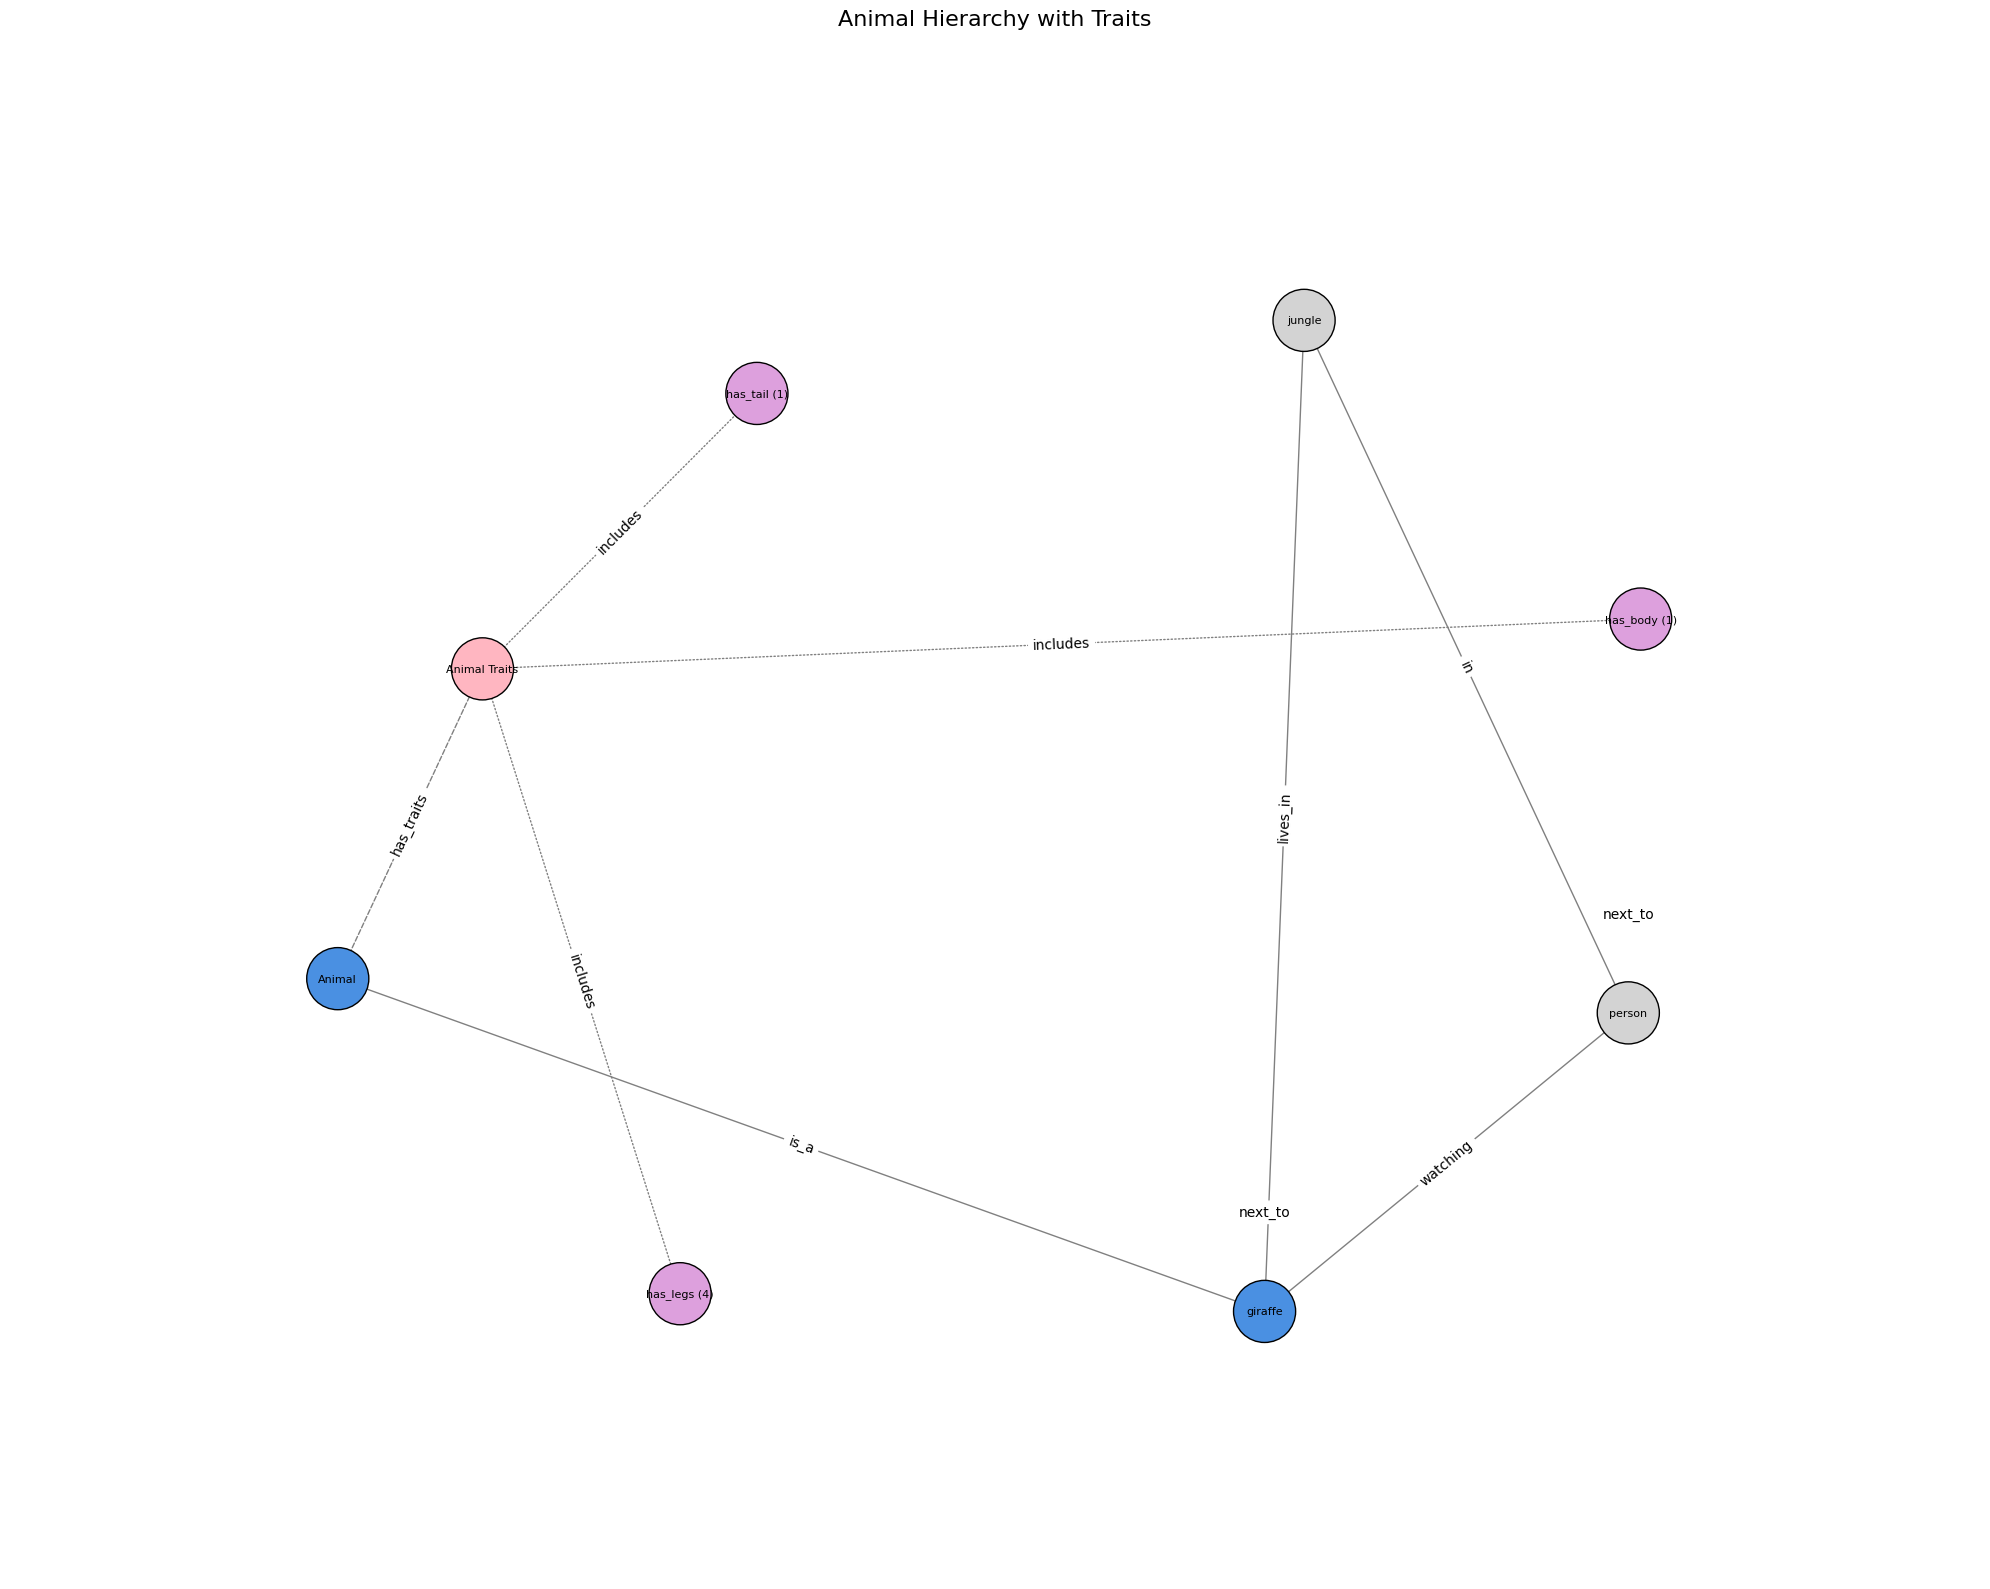

In [ ]:
merger = SceneGraphMerger()
merged_graph = merger.merge_scene_graphs(scene_graphs)
print(type(merged_graph))
print(merged_graph['nodes'])  # if `nodes` is an attribute of the object)
merger.visualize_merged_scene_graph(merged_graph)